# EDA by date

This notebook explores the train data, to evaluate whether there are patterns related to specific months or times of the year.

In this competition, the test data is anonymzed and shuffled, meaning that we do not have access to the timestamps. Yet, if there are patterns related to specific times of the year, we may try to infer them and use them to improve predictions. (see also this notebook for the prediction https://www.kaggle.com/code/dalloliogm/rev-engineering-the-original-order-of-test-rows)

In [1]:
import polars as pl
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import umap
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Load and shrink data ---
train_df = pl.read_parquet('/kaggle/input/drw-crypto-market-prediction/train.parquet')
train_df = train_df.select(pl.all().shrink_dtype()).to_pandas()

# --- 2. Add calendar features ---
train_df['date'] = pd.to_datetime(train_df['timestamp'], unit='s')
train_df['month'] = train_df['date'].dt.month
train_df['dayofweek'] = train_df['date'].dt.dayofweek
train_df['is_tax_season'] = train_df['month'].isin([3, 4]).astype(int)
train_df['is_q_end'] = train_df['date'].dt.is_quarter_end.astype(int)





2025-05-28 13:21:33.752226: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748438494.029773      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748438494.110725      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
train_df.head()

,bid_qty,ask_qty,buy_qty,sell_qty,volume,X1,X2,X3,X4,X5,...,X888,X889,X890,label,timestamp,date,month,dayofweek,is_tax_season,is_q_end
0,15.283000,8.425000,176.404999,44.984001,221.389008,0.121263,-0.417690,0.005399,0.125949,0.058359,...,0.210153,0.159183,0.530636,0.562539,2023-03-01 00:00:00,2023-03-01 00:00:00,3,2,1,0
1,38.590000,2.336000,525.846008,321.950012,847.796021,0.302841,-0.049576,0.356667,0.481087,0.237954,...,0.209573,0.158963,0.530269,0.533686,2023-03-01 00:01:00,2023-03-01 00:01:00,3,2,1,0
2,0.442000,60.250000,159.227005,136.369003,295.596008,0.167462,-0.291212,0.083138,0.206881,0.101727,...,0.208993,0.158744,0.529901,0.546505,2023-03-01 00:02:00,2023-03-01 00:02:00,3,2,1,0
3,4.865000,21.016001,335.742004,124.962997,460.704987,0.072944,-0.436590,-0.102483,0.017551,0.007149,...,0.208416,0.158524,0.529534,0.357703,2023-03-01 00:03:00,2023-03-01 00:03:00,3,2,1,0
4,27.158001,3.451000,98.411003,44.407001,142.817993,0.173820,-0.213489,0.096067,0.215709,0.107133,...,0.207839,0.158304,0.529167,0.362452,2023-03-01 00:04:00,2023-03-01 00:04:00,3,2,1,0


In [3]:
train_df.shape

(525887, 902)

In [4]:
train_df.month.value_counts()

month
3     44640
5     44638
10    44637
7     44546
12    44518
1     44482
8     44385
6     43200
11    43200
4     43050
9     42854
2     41737
Name: count, dtype: int64

In [5]:
# --- 3. Select numeric features ---
feature_cols = [col for col in train_df.columns if col.startswith('X') or col in ['bid_qty', 'ask_qty', 'buy_qty', 'sell_qty', 'volume']]
X = train_df[feature_cols].replace([np.inf, -np.inf], np.nan).fillna(0).astype(np.float32)

# Optional: Subsample to 20k rows to plot faster
#X = X.sample(n=20000, random_state=42)
meta = train_df.loc[X.index, ['month', 'dayofweek', 'is_tax_season', 'is_q_end']]



In [6]:
X.head()

,bid_qty,ask_qty,buy_qty,sell_qty,volume,X1,X2,X3,X4,X5,...,X881,X882,X883,X884,X885,X886,X887,X888,X889,X890
0,15.283000,8.425000,176.404999,44.984001,221.389008,0.121263,-0.417690,0.005399,0.125949,0.058359,...,1.000007,1.925423,1.847943,0.005676,0.190791,0.369691,0.377630,0.210153,0.159183,0.530636
1,38.590000,2.336000,525.846008,321.950012,847.796021,0.302841,-0.049576,0.356667,0.481087,0.237954,...,1.003153,1.928569,1.849468,0.005227,0.184660,0.363642,0.374515,0.209573,0.158963,0.530269
2,0.442000,60.250000,159.227005,136.369003,295.596008,0.167462,-0.291212,0.083138,0.206881,0.101727,...,1.002501,1.928047,1.849282,0.004796,0.178719,0.357689,0.371424,0.208993,0.158744,0.529901
3,4.865000,21.016001,335.742004,124.962997,460.704987,0.072944,-0.436590,-0.102483,0.017551,0.007149,...,1.002985,1.928621,1.849608,0.004398,0.172967,0.351832,0.368358,0.208416,0.158524,0.529534
4,27.158001,3.451000,98.411003,44.407001,142.817993,0.173820,-0.213489,0.096067,0.215709,0.107133,...,1.001286,1.927084,1.848950,0.004008,0.167391,0.346066,0.365314,0.207839,0.158304,0.529167


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


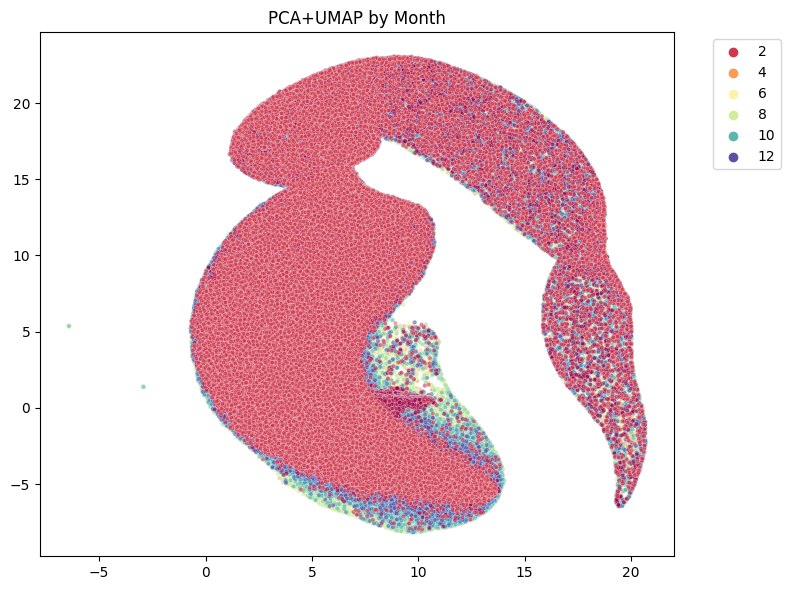

In [7]:
# --- 4. Dimensionality reduction (PCA + UMAP) ---
pca = PCA(n_components=50).fit_transform(X)
embedding = umap.UMAP(n_neighbors=30, min_dist=0.3, random_state=42).fit_transform(pca)

# --- 5. Plot helper ---
def plot_embedding(embedding, labels, title):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=embedding[:,0], y=embedding[:,1], hue=labels, palette='Spectral', s=10, alpha=0.6)
    plt.title(title)
    plt.legend(title='', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# --- 6. Visualizations ---
plot_embedding(embedding, meta['month'], 'PCA+UMAP by Month')

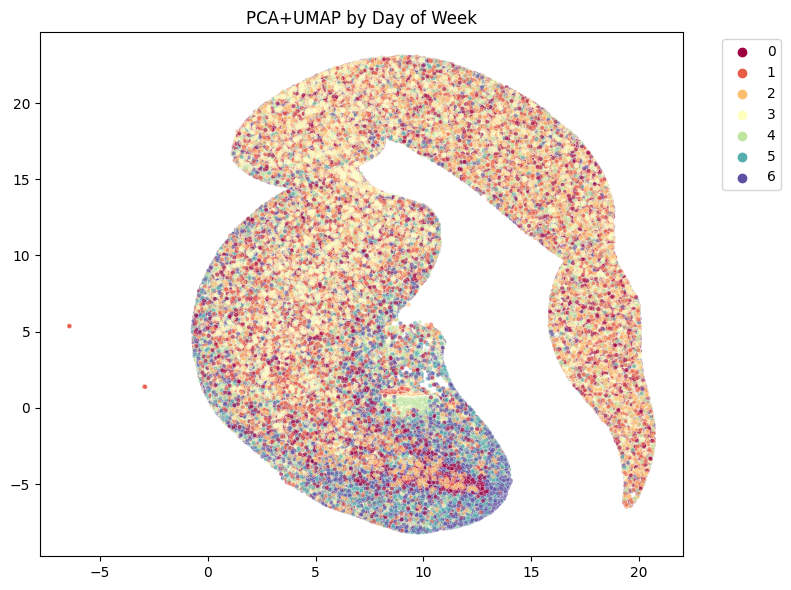

In [8]:
plot_embedding(embedding, meta['dayofweek'], 'PCA+UMAP by Day of Week')


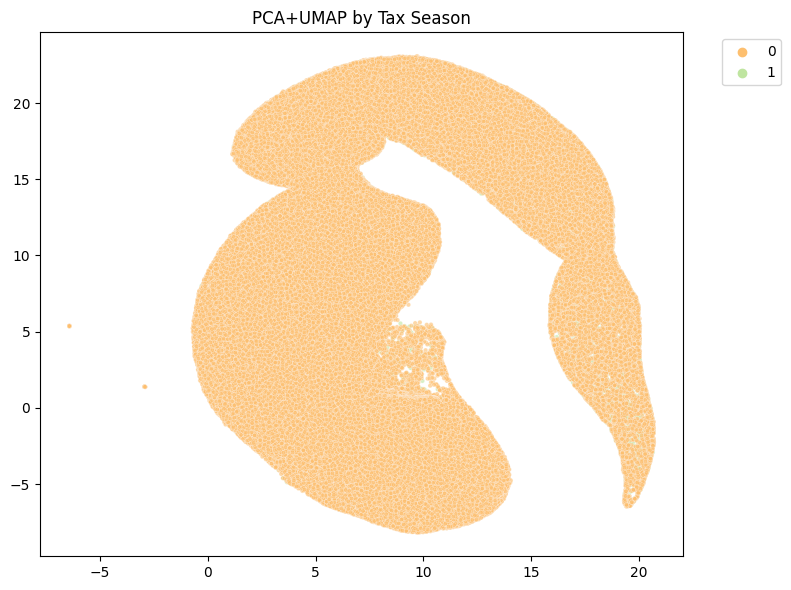

In [9]:
plot_embedding(embedding, meta['is_tax_season'], 'PCA+UMAP by Tax Season')


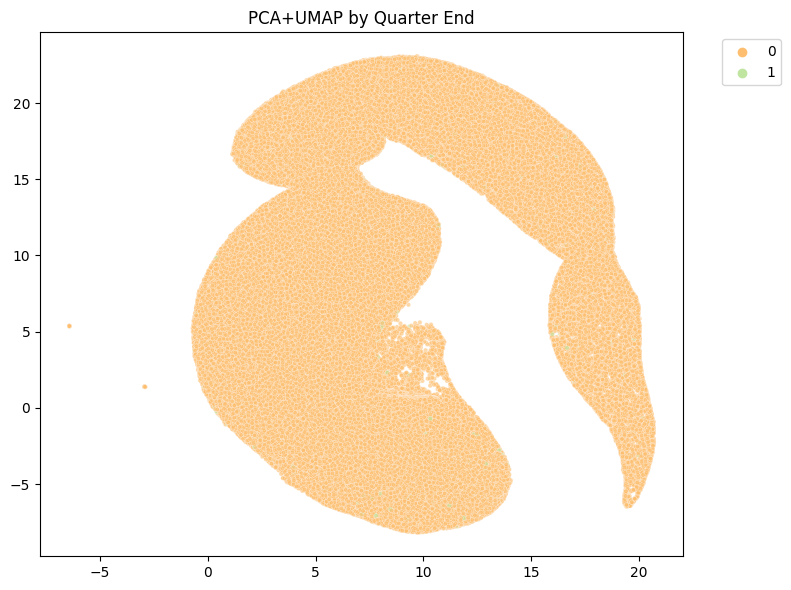

In [10]:
plot_embedding(embedding, meta['is_q_end'], 'PCA+UMAP by Quarter End')